# Project #7 : Implement a scoring model

The aim of this project is to build a scoring model that will give a prediction on the probability of bankruptcy of a customer automatically. To do this, we use data from a financial firm that offers consumer credit for people with little or no loan history.
The data are available at the following address:
https://www.kaggle.com/c/home-credit-default-risk/data

The dataset consists of two main databases (*application_train* and *application_test*). Additional data from previous loan applications in the same company and/or in others are available for clients with a loan history. Moreover, there one database that provides a description of all the variables of the different databases.

First, the main datasets will be joined to form one around the clients. Then, this dataset will be cleaned in order to prepare the it for the modelling phase. A pre-existing kernel has been adapted for the prepocess. We have written supplement functions and imported them as a module.

## Sommaire
1. Aggregations
    1. Training and testing sets
    2. bureau
    3. bureau_balance
    4. Montly cash data
    5. Montly credit data
    6. Previous application
    7. installment payments
2. Exploratory Data Analysis
    1. Target
    2. Gender
    3. Days birth (age)
    4. income of the client
    5. income type
3. Feature engineering and selection
    1. Variables encoding
    2. Missing values
    3. Correlations

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# set the working directory
import os
os.chdir("/content/gdrive/My Drive/Colab_Notebooks/")

In [0]:
# Load the used packages and set the workplace

%matplotlib inline

# Standard libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# memory usage
import gc

# load the written functions for this project
import modules_projet7 as mp

#import warnings  # hide warning message
#warnings.filterwarnings("ignore")

In [0]:
path = "./Projet+Mise+en+prod+-+home-credit-default-risk/"

In [0]:
#df = pd.read_csv(path+"application_train.csv", sep=",")
#df = pd.read_csv(path+"application_test.csv", sep=",")
#df = pd.read_csv(path+"bureau.csv", sep=",")
#df = pd.read_csv(path+"bureau_balance.csv", sep=",")
#df = pd.read_csv(path+"credit_card_balance.csv", sep=",")
#df = pd.read_csv(path+"HomeCredit_columns_description.csv", sep=",", encoding="latin_1")
#df = pd.read_csv(path+"installments_payments.csv", sep=",")
#df = pd.read_csv(path+"POS_CASH_balance.csv", sep=",")
#df = pd.read_csv(path+"previous_application.csv", sep=",")
#df = pd.read_csv(path+"sample_submission.csv", sep=",")

# Aggregations

This part applies the various preprocessing functions written in a module for this project. It will aggregate the datasets and towards the client and then join them. The numeric variables will be aggregated according to the total, the average, the minimum and maximum values (function *agg_numeric* in the module). As for the categorical columns, they are aggregated using the *count_categorical* function. The function returns an aggregated dataframe by summing and normalizing the values. Both information indicate the same thing but in different formats. Keeping both of them will not add any additional information for the modeling, we will only keep one (the normalized value).

Futhermore, after loading the dataframes, we use a function (*convert_types*) which helps reducing memory usage by using more efficient types for the variables. For example, category is often a better type than object (unless the number of unique categories is close to the number of rows in the dataframe).

In [0]:
# Use None to read all the file or an int to select a piece of the file
number_rows=None
#number_rows = 2000

## Training and testing sets

**application_{train/test}:** This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET). Static data for all applications. One row represents one loan in our data sample.

In [8]:
train = pd.read_csv(path+"application_train.csv", sep=",", nrows=number_rows)
train = mp.convert_types(train)

test = pd.read_csv(path+"application_test.csv", sep=",", nrows=number_rows)
test = mp.convert_types(test)

# Initial variables without the target
initial_columns = list(test.columns)

Original Memory Usage: 0.3 gb.
New Memory Usage: 0.135 gb.
Original Memory Usage: 0.047 gb.
New Memory Usage: 0.021 gb.


In [9]:
print("Training set sahpe : ",train.shape)
print("Testing set shape : ", test.shape)
print("Number of initial variables excluding the target : ", len(initial_columns))

Training set sahpe :  (307511, 122)
Testing set shape :  (48744, 121)
Number of initial variables excluding the target :  121


In [0]:
# Concat the training and the testing df
# Add a column to specify the origin of the entries (if in train or test set)
train['ORIGIN'] = train.apply(lambda x: 'train', axis=1)
test['ORIGIN'] = test.apply(lambda x: 'test', axis=1)
#train_test = pd.concat([train, test], join='inner', ignore_index=True)  # drop the target
train_test = pd.concat([train, test], join='outer', ignore_index=True, sort=True)  # keep the target

# Other method
#train_test = pd.concat([train, test], sort=False, ignore_index=True)
#train_test['ORIGIN'] = train_test['TARGET'].apply(lambda x: 'train' if x is not np.nan else 'test')
#del train_test['TARGET']

In [11]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 123 entries, AMT_ANNUITY to YEARS_BUILD_MODE
dtypes: category(13), float32(65), float64(1), int32(40), object(4)
memory usage: 160.7+ MB


In [6]:
# Duplicated entries
print(train_test.shape)
print(train_test.drop_duplicates().shape) 
print(train_test.drop_duplicates(subset="SK_ID_CURR").shape) 

(356255, 123)
(356255, 123)
(356255, 123)


There is no duplicated row or entry.

## bureau

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

### Exploration of bureau

In [12]:
bureau = pd.read_csv(path+"bureau.csv", sep=",", nrows=number_rows)
bureau = mp.convert_types(bureau)

Original Memory Usage: 0.233 gb.
New Memory Usage: 0.101 gb.


In [13]:
bureau.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1716428 entries, 0 to 1716427
Data columns (total 17 columns):
SK_ID_CURR                int32
SK_ID_BUREAU              int32
CREDIT_ACTIVE             category
CREDIT_CURRENCY           category
DAYS_CREDIT               int32
CREDIT_DAY_OVERDUE        int32
DAYS_CREDIT_ENDDATE       float32
DAYS_ENDDATE_FACT         float32
AMT_CREDIT_MAX_OVERDUE    float32
CNT_CREDIT_PROLONG        int32
AMT_CREDIT_SUM            float32
AMT_CREDIT_SUM_DEBT       float32
AMT_CREDIT_SUM_LIMIT      float32
AMT_CREDIT_SUM_OVERDUE    float32
CREDIT_TYPE               category
DAYS_CREDIT_UPDATE        int32
AMT_ANNUITY               float32
dtypes: category(3), float32(8), int32(6)
memory usage: 96.6 MB


In [14]:
bureau.head()

SK_ID_CURR  SK_ID_BUREAU  ... DAYS_CREDIT_UPDATE AMT_ANNUITY
0      215354       5714462  ...               -131         NaN
1      215354       5714463  ...                -20         NaN
2      215354       5714464  ...                -16         NaN
3      215354       5714465  ...                -16         NaN
4      215354       5714466  ...                -21         NaN

[5 rows x 17 columns]

In [15]:
mp.missing_values_table(bureau)

column_dtype  ...  missing_value_ratio
AMT_ANNUITY                 float32  ...               71.473
AMT_CREDIT_MAX_OVERDUE      float32  ...               65.513
DAYS_ENDDATE_FACT           float32  ...               36.917
AMT_CREDIT_SUM_LIMIT        float32  ...               34.477
AMT_CREDIT_SUM_DEBT         float32  ...               15.012
DAYS_CREDIT_ENDDATE         float32  ...                6.150
AMT_CREDIT_SUM              float32  ...                0.001
CREDIT_ACTIVE              category  ...                0.000
CREDIT_CURRENCY            category  ...                0.000
DAYS_CREDIT                   int32  ...                0.000
CREDIT_DAY_OVERDUE            int32  ...                0.000
SK_ID_BUREAU                  int32  ...                0.000
CNT_CREDIT_PROLONG            int32  ...                0.000
AMT_CREDIT_SUM_OVERDUE      float32  ...                0.000
CREDIT_TYPE                category  ...                0.000
DAYS_CREDIT_UPDATE            int32  ...                0.000
SK_ID_CURR                    int32  ...                0.000

[17 rows x 5 columns]

**Ces différentes séries (*'AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 'DAYS_ENDDATE_FACT'*) présentent trop de valeurs manquantes. Nous décidons de les supprimer du jeu de données avant aggrégation**

In [0]:
# Drop these columns
bureau.drop(columns=['AMT_CREDIT_SUM_LIMIT','AMT_ANNUITY', 'AMT_CREDIT_MAX_OVERDUE', 
                     'DAYS_ENDDATE_FACT', 'AMT_CREDIT_SUM_DEBT'], inplace=True)

### Aggregations of *bureau* 

In [0]:
# Generate bureau df by client
bureau_by_client = mp.aggregate_client(bureau, group_vars=['SK_ID_BUREAU','SK_ID_CURR'], 
                                    df_names=['bureau', 'client'])

In [18]:
bureau_by_client.head()

SK_ID_CURR  ...  client_AMT_CREDIT_SUM_sum
0      100001  ...               1.453365e+06
1      100002  ...               8.650556e+05
2      100003  ...               1.017400e+06
3      100004  ...               1.890378e+05
4      100005  ...               6.571260e+05

[5 rows x 55 columns]

In [19]:
bureau_by_client.shape

(305811, 55)

In [0]:
# Insert Computed Features into Training/Testing Data

# Merge with the informations of bureau grouped by client
train_test = train_test.merge(bureau_by_client, on='SK_ID_CURR', how='left')

## bureau_balance

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows. 

### Exploration

In [21]:
bureau_balance = pd.read_csv(path+"bureau_balance.csv", sep=",", nrows=number_rows)
bureau_balance = mp.convert_types(bureau_balance)

Original Memory Usage: 0.655 gb.
New Memory Usage: 0.246 gb.


In [22]:
bureau_balance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27299925 entries, 0 to 27299924
Data columns (total 3 columns):
SK_ID_BUREAU      int32
MONTHS_BALANCE    int32
STATUS            category
dtypes: category(1), int32(2)
memory usage: 234.3 MB


In [23]:
bureau_balance.head()

SK_ID_BUREAU  MONTHS_BALANCE STATUS
0       5715448               0      C
1       5715448              -1      C
2       5715448              -2      C
3       5715448              -3      C
4       5715448              -4      C

In [24]:
mp.missing_values_table(bureau_balance)

column_dtype  value_count  ...  missing_value  missing_value_ratio
SK_ID_BUREAU          int32     27299925  ...              0                  0.0
MONTHS_BALANCE        int32     27299925  ...              0                  0.0
STATUS             category     27299925  ...              0                  0.0

[3 rows x 5 columns]

**Jeu de données rempli à 100%**

Status of Credit Bureau loan during the month: *active*, *closed*, *DPD0-30* (DPD = days past due), etc.
- C means closed, 
- X means status unknown, 
- 0 means no DPD, 
- 1 means maximal did during month between 1-30, 
- 2 means DPD 31-60,
- ...
- 5 means DPD 120+ or sold or written off.

In [25]:
bureau_balance['STATUS'].value_counts()

C    13646993
0     7499507
X     5810482
1      242347
5       62406
2       23419
3        8924
4        5847
Name: STATUS, dtype: int64

### Aggregations of *bureau_balance*

We first group the values according to the credits (the same credit being spread out over several months) then according to the customers (the same customer can have several credits).

In [0]:
# Value counts of bureau_balance by loan
bureau_balance_counts = mp.agg_categorical(bureau_balance, group_var='SK_ID_BUREAU', 
                                          df_name='bureau_balance', functions=['mean'])

# Aggregated stats of Bureau Balance dataframe by loan
bureau_balance_agg = mp.agg_numeric(bureau_balance, group_var='SK_ID_BUREAU', 
                                 df_name='bureau_balance')

In [0]:
# Aggregated Stats of Bureau Balance by Client

# Dataframe grouped by the loan
bureau_balance_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index=True,
                                          left_on='SK_ID_BUREAU', how='outer')

# Merge to include the SK_ID_CURR
bureau_balance_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_balance_by_loan, 
                                                              on='SK_ID_BUREAU', how='left')

# Aggregate the stats for each client
bureau_balance_by_client = mp.agg_numeric(bureau_balance_by_loan.drop(columns=['SK_ID_BUREAU']), 
                                       group_var='SK_ID_CURR', df_name='client')

In [28]:
bureau_balance_by_client.head()

client_bureau_balance_MONTHS_BALANCE_sum_sum  ...  SK_ID_CURR
0                                       -2800.0  ...      100001
1                                       -2701.0  ...      100002
2                                           0.0  ...      100003
3                                           0.0  ...      100004
4                                         -91.0  ...      100005

[5 rows x 54 columns]

In [29]:
# Insert Computed Features into Training/Testing Data

# Merge with the monthly information grouped by client
train_test = train_test.merge(bureau_balance_by_client, on='SK_ID_CURR', how='left')

# Delete initial df
gc.enable()
del bureau, bureau_by_client, bureau_balance, bureau_balance_by_client
gc.collect()

11

## Montly cash data

**POS_CASH_balance**: Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [30]:
cash = pd.read_csv(path+"POS_CASH_balance.csv", sep=",", nrows=number_rows)
cash = mp.convert_types(cash)

Original Memory Usage: 0.64 gb.
New Memory Usage: 0.29 gb.


In [31]:
cash.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001358 entries, 0 to 10001357
Data columns (total 8 columns):
SK_ID_PREV               int32
SK_ID_CURR               int32
MONTHS_BALANCE           int32
CNT_INSTALMENT           float32
CNT_INSTALMENT_FUTURE    float32
NAME_CONTRACT_STATUS     category
SK_DPD                   int32
SK_DPD_DEF               int32
dtypes: category(1), float32(2), int32(5)
memory usage: 276.6 MB


In [32]:
cash.head()

SK_ID_PREV  SK_ID_CURR  ...  SK_DPD  SK_DPD_DEF
0     1803195      182943  ...       0           0
1     1715348      367990  ...       0           0
2     1784872      397406  ...       0           0
3     1903291      269225  ...       0           0
4     2341044      334279  ...       0           0

[5 rows x 8 columns]

In [33]:
mp.missing_values_table(cash)

column_dtype  ...  missing_value_ratio
CNT_INSTALMENT             float32  ...                0.261
CNT_INSTALMENT_FUTURE      float32  ...                0.261
SK_ID_PREV                   int32  ...                0.000
SK_ID_CURR                   int32  ...                0.000
MONTHS_BALANCE               int32  ...                0.000
NAME_CONTRACT_STATUS      category  ...                0.000
SK_DPD                       int32  ...                0.000
SK_DPD_DEF                   int32  ...                0.000

[8 rows x 5 columns]

In [34]:
cash['NAME_CONTRACT_STATUS'].value_counts()

Active                   9151119
Completed                 744883
Signed                     87260
Demand                      7065
Returned to the store       5461
Approved                    4917
Amortized debt               636
Canceled                      15
XNA                            2
Name: NAME_CONTRACT_STATUS, dtype: int64

For this dataset ('*cash*') we will keep all the columns for the grouping by credit then by customer.

In [0]:
cash_by_client = mp.aggregate_client(cash, group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                  df_names=['cash', 'client'])

In [36]:
cash_by_client.head()

client_cash_MONTHS_BALANCE_sum_sum  ...  SK_ID_CURR
0                               -2887  ...      100001
1                               -3610  ...      100002
2                              -13240  ...      100003
3                                -408  ...      100004
4                               -2420  ...      100005

[5 rows x 131 columns]

In [37]:
# Insert Computed Features into Training/Testing Data

train_test = train_test.merge(cash_by_client, on='SK_ID_CURR', how='left')

# Delete initial df
gc.enable()
del cash, cash_by_client
gc.collect()

0

## Montly credit data

**credit_card_balance**
Monthly balance snapshots of previous credit cards that the applicant has with Home Credit. This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample - i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [38]:
credit = pd.read_csv(path+"credit_card_balance.csv", sep=",", nrows=number_rows)
credit = mp.convert_types(credit)

Original Memory Usage: 0.707 gb.
New Memory Usage: 0.342 gb.


In [39]:
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3840312 entries, 0 to 3840311
Data columns (total 23 columns):
SK_ID_PREV                    int32
SK_ID_CURR                    int32
MONTHS_BALANCE                int32
AMT_BALANCE                   float32
AMT_CREDIT_LIMIT_ACTUAL       int32
AMT_DRAWINGS_ATM_CURRENT      float32
AMT_DRAWINGS_CURRENT          float32
AMT_DRAWINGS_OTHER_CURRENT    float32
AMT_DRAWINGS_POS_CURRENT      float32
AMT_INST_MIN_REGULARITY       float32
AMT_PAYMENT_CURRENT           float32
AMT_PAYMENT_TOTAL_CURRENT     float32
AMT_RECEIVABLE_PRINCIPAL      float32
AMT_RECIVABLE                 float32
AMT_TOTAL_RECEIVABLE          float32
CNT_DRAWINGS_ATM_CURRENT      float32
CNT_DRAWINGS_CURRENT          int32
CNT_DRAWINGS_OTHER_CURRENT    float32
CNT_DRAWINGS_POS_CURRENT      float32
CNT_INSTALMENT_MATURE_CUM     float32
NAME_CONTRACT_STATUS          category
SK_DPD                        int32
SK_DPD_DEF                    int32
dtypes: category(1), float

In [40]:
credit_by_client = mp.aggregate_client(credit, group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                    df_names=['credit', 'client'])
credit_by_client.head()

client_credit_MONTHS_BALANCE_sum_sum  ...  client_credit_AMT_DRAWINGS_ATM_CURRENT_max_max
0                                  -126  ...                                             NaN
1                               -210826  ...                                        180000.0
2                               -446976  ...                                        157500.0
3                                 -2890  ...                                             NaN
4                                  -480  ...                                             NaN

[5 rows x 358 columns]

In [41]:
# Insert Computed Features into Training/Testing Data

train_test = train_test.merge(credit_by_client, on='SK_ID_CURR', how='left')

# Delete initial df
gc.enable()
del credit, credit_by_client
gc.collect()

0

## Previous application data

**previous_application**: All previous applications for Home Credit loans of clients who have loans in our sample. There is one row for each previous application related to loans in our data sample.

In [42]:
previous = pd.read_csv(path+'previous_application.csv', nrows=number_rows)
previous = mp.convert_types(previous)

Original Memory Usage: 0.494 gb.
New Memory Usage: 0.167 gb.


In [43]:
previous.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 37 columns):
SK_ID_PREV                     1670214 non-null int32
SK_ID_CURR                     1670214 non-null int32
NAME_CONTRACT_TYPE             1670214 non-null category
AMT_ANNUITY                    1297979 non-null float32
AMT_APPLICATION                1670214 non-null float32
AMT_CREDIT                     1670213 non-null float32
AMT_DOWN_PAYMENT               774370 non-null float32
AMT_GOODS_PRICE                1284699 non-null float32
WEEKDAY_APPR_PROCESS_START     1670214 non-null category
HOUR_APPR_PROCESS_START        1670214 non-null int32
FLAG_LAST_APPL_PER_CONTRACT    1670214 non-null category
NFLAG_LAST_APPL_IN_DAY         1670214 non-null int32
RATE_DOWN_PAYMENT              774370 non-null float32
RATE_INTEREST_PRIMARY          5951 non-null float32
RATE_INTEREST_PRIVILEGED       5951 non-null float32
NAME_CASH_LOAN_PURPOSE         1670214 non-null category
NAM

In [44]:
previous.head()

SK_ID_PREV  SK_ID_CURR  ... DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL
0     2030495      271877  ...            -37.0                        0.0
1     2802425      108129  ...         365243.0                        1.0
2     2523466      122040  ...         365243.0                        1.0
3     2819243      176158  ...           -177.0                        1.0
4     1784265      202054  ...              NaN                        NaN

[5 rows x 37 columns]

In [45]:
previous_by_client = mp.aggregate_client(previous, group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                    df_names=['previous', 'client'])
previous_by_client.head()

SK_ID_CURR  ...  client_RATE_INTEREST_PRIVILEGED_max
0      100001  ...                                  NaN
1      100002  ...                                  NaN
2      100003  ...                                  NaN
3      100004  ...                                  NaN
4      100005  ...                                  NaN

[5 rows x 227 columns]

In [46]:
# Insert Computed Features into Training/Testing Data

train_test = train_test.merge(previous_by_client, on='SK_ID_CURR', how='left')

# Delete initial df
gc.enable()
del previous, previous_by_client
gc.collect()

0

## installment payments

**installment_payments:** Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample. There is a) one row for every payment that was made plus b) one row each for missed payment. One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [47]:
payments = pd.read_csv(path+'installments_payments.csv', nrows=number_rows)
payments = mp.convert_types(payments)

Original Memory Usage: 0.871 gb.
New Memory Usage: 0.435 gb.


In [48]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13605401 entries, 0 to 13605400
Data columns (total 8 columns):
SK_ID_PREV                int32
SK_ID_CURR                int32
NUM_INSTALMENT_VERSION    float32
NUM_INSTALMENT_NUMBER     int32
DAYS_INSTALMENT           float32
DAYS_ENTRY_PAYMENT        float32
AMT_INSTALMENT            float32
AMT_PAYMENT               float32
dtypes: float32(5), int32(3)
memory usage: 415.2 MB


In [49]:
payments.head()

SK_ID_PREV  SK_ID_CURR  ...  AMT_INSTALMENT   AMT_PAYMENT
0     1054186      161674  ...     6948.359863   6948.359863
1     1330831      151639  ...     1716.525024   1716.525024
2     2085231      193053  ...    25425.000000  25425.000000
3     2452527      199697  ...    24350.130859  24350.130859
4     2714724      167756  ...     2165.040039   2160.584961

[5 rows x 8 columns]

In [50]:
payments_by_client = mp.aggregate_client(payments, group_vars=['SK_ID_PREV', 'SK_ID_CURR'], 
                                    df_names=['payments', 'client'])
payments_by_client.head()

client_payments_DAYS_ENTRY_PAYMENT_sum_sum  ...  client_payments_AMT_INSTALMENT_sum_sum
0                                    -52813.0  ...                            1.528387e+05
1                                   -113867.0  ...                            4.172888e+06
2                                   -367137.0  ...                            1.134881e+07
3                                     -6855.0  ...                            6.386539e+04
4                                    -49374.0  ...                            5.054566e+05

[5 rows x 107 columns]

In [51]:
# Insert Computed Features into Training/Testing Data

train_test = train_test.merge(payments_by_client, on='SK_ID_CURR', how='left')

# Delete initial df
gc.enable()
del payments, payments_by_client
gc.collect()

0

## Save the outpout

In [52]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 0 to 356254
Columns: 1049 entries, AMT_ANNUITY to client_payments_AMT_INSTALMENT_sum_sum
dtypes: category(13), float32(489), float64(503), int32(40), object(4)
memory usage: 2.1+ GB


In [53]:
os.getcwd()

'/content/gdrive/My Drive/Colab_Notebooks'

In [0]:
# Save the results in a csv file
train_test.to_csv('train_test.csv', index=False, sep=',')

# Exploratory Data Analysis

**Exploratory Data Analysis (EDA)** is an approach to analyzing data sets to summarize their main characteristics. Therefore, we will present the summary statistics of selected variables and plot their distribution in order to improve our knowledge of the dataset and point out some general aspects.

In [55]:
# Reload the merge dataframe
train_test = pd.read_csv('./train_test.csv', sep=',', low_memory=True)
train_test = mp.convert_types(train_test)

Original Memory Usage: 2.99 gb.
New Memory Usage: 1.477 gb.


In [56]:
train_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356255 entries, 0 to 356254
Columns: 1049 entries, AMT_ANNUITY to client_payments_AMT_INSTALMENT_sum_sum
dtypes: category(17), float32(992), int32(40)
memory usage: 1.4 GB


In [0]:
# Use only the application_train entries
train_set = train_test[train_test['ORIGIN']=='train'].copy()

In [58]:
# Delete initial df
gc.enable()
del train_test
gc.collect()

0

In [59]:
train_set['SK_ID_CURR'].dtype

dtype('int32')

## Target

Target variable (1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample, 0 - all other cases)

Text(0.5, 1.0, 'Distribution of the target value')

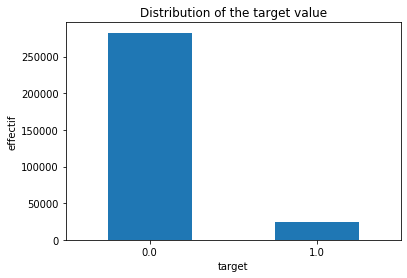

In [60]:
fig, ax = plt.subplots()
train_set['TARGET'].value_counts().plot.bar(ax=ax, rot=0)
ax.set_xlabel('target')
ax.set_ylabel('effectif')
ax.set_title('Distribution of the target value')

We have unbalanced data regarding the target. Fortunately, there are few client with payment difficulties. Since, we want to predict the probability of a client to fail in installment payments, this fact will biased the classification results. We will address this issue and balance the dataframe.

## Gender

Gender of the client

Text(0.5, 0.98, 'Gender of the client')

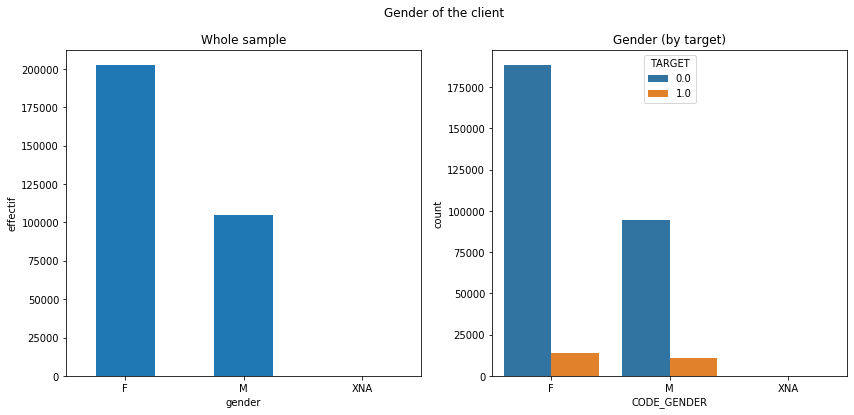

In [61]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
train_set['CODE_GENDER'].value_counts().plot.bar(ax=ax1, rot=0)
ax1.set_title('Whole sample')
ax1.set_xlabel('gender')
ax1.set_ylabel('effectif')

ax2 = sns.countplot(x='CODE_GENDER', data=train_set,hue='TARGET')
ax2.set_title('Gender (by target)')

plt.suptitle('Gender of the client')

## Days birth (age)

Client's age in days at the time of application

Text(0.5, 1.0, 'pyramide des âges')

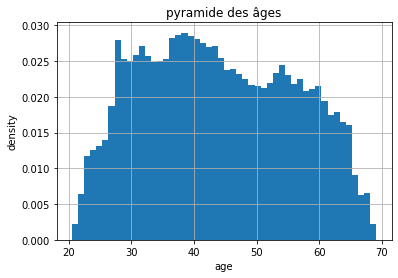

In [62]:
# to get the age we need to divise the number of days by -365
fig, ax = plt.subplots()
(train_set['DAYS_BIRTH']/-365).hist(bins=50,density=True, ax=ax)
ax.set_xlabel('age')
ax.set_ylabel('density')
ax.set_title('pyramide des âges')

## income of the client

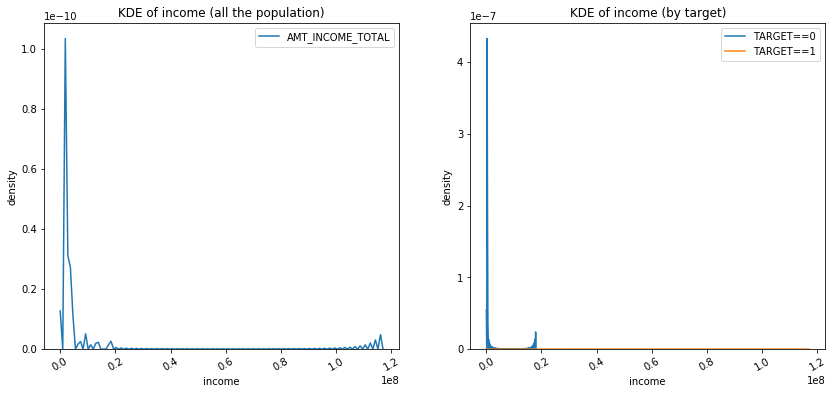

In [63]:
# KDE (kernel density dsistribution) plot
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6))
sns.kdeplot(train_set['AMT_INCOME_TOTAL'], ax=ax1)
ax1.set_title('KDE of income (all the population)')

sns.kdeplot(train_set.loc[train_set['TARGET']==0,'AMT_INCOME_TOTAL'], LABEL='TARGET==0')
sns.kdeplot(train_set.loc[train_set['TARGET']==1,'AMT_INCOME_TOTAL'], LABEL='TARGET==1')
ax2.set_title('KDE of income (by target)')

for ax in fig.axes:
    ax.set_xlabel('income')
    ax.set_ylabel('density')
    for label in ax.get_xticklabels():
        label.set_rotation(30)

## income type

Text(0.5, 0.98, 'Catégorie socio-professionnelle')

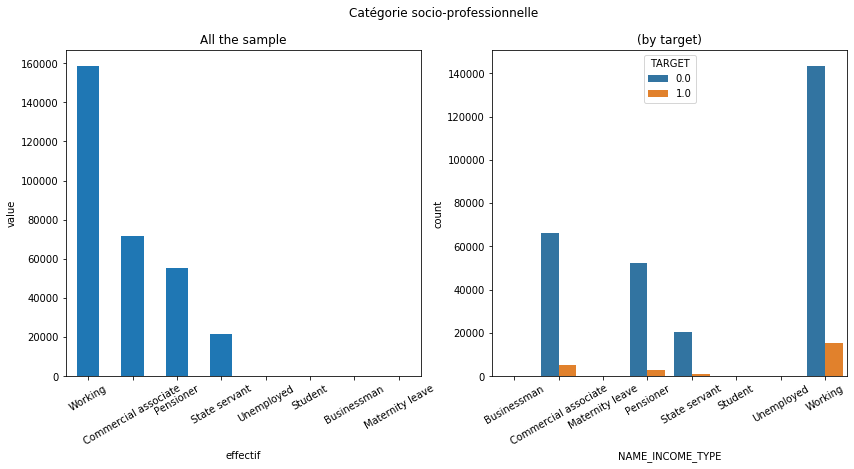

In [64]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
train_set['NAME_INCOME_TYPE'].value_counts().plot.bar(ax=ax1)
ax1.set_title('All the sample')
ax1.set_xlabel('effectif')
ax1.set_ylabel('value')

ax2 = sns.countplot(x='NAME_INCOME_TYPE', data=train_set,hue='TARGET')
ax2.set_title('(by target)')

for ax in fig.axes:
    #ax.set_xlabel('income')
    #ax.set_ylabel('density')
    for label in ax.get_xticklabels():
        label.set_rotation(30)

plt.suptitle('Catégorie socio-professionnelle')

# Feature engineering and selection

## Variables encoding

For the encoding of the categorical features, we use the OneHotEncoding

In [65]:
# One hot encoding
train_set.drop(columns=['ORIGIN'], inplace=True)
train_set = pd.get_dummies(train_set, prefix_sep='=')
train_set.shape

(307511, 1172)

In [66]:
# Check if there are columns with id information except 'SK_ID_CURR'
for col in train_set.columns:
    if 'SK_ID' in col:
        print(col)
    elif 'ORIGIN' in col:
        print(col)

SK_ID_CURR


## Drop columns with missing values ratio above a threshold

In [67]:
# Show missing value table with thresold = 90%
mp.missing_values_table(train_set)[['column_dtype', 'missing_value_ratio']].head(20)

column_dtype  missing_value_ratio
client_RATE_INTEREST_PRIVILEGED_max                     float32               98.501
client_RATE_INTEREST_PRIVILEGED_mean                    float32               98.501
client_RATE_INTEREST_PRIVILEGED_min                     float32               98.501
client_RATE_INTEREST_PRIMARY_max                        float32               98.501
client_RATE_INTEREST_PRIMARY_mean                       float32               98.501
client_RATE_INTEREST_PRIMARY_min                        float32               98.501
client_credit_AMT_PAYMENT_CURRENT_min_mean              float32               80.144
client_credit_AMT_PAYMENT_CURRENT_mean_max              float32               80.144
client_credit_AMT_PAYMENT_CURRENT_min_min               float32               80.144
client_credit_AMT_PAYMENT_CURRENT_min_max               float32               80.144
client_credit_AMT_PAYMENT_CURRENT_mean_min              float32               80.144
client_credit_AMT_PAYMENT_CURRENT_mean_mean             float32               80.144
client_credit_AMT_PAYMENT_CURRENT_max_min               float32               80.144
client_credit_AMT_PAYMENT_CURRENT_max_mean              float32               80.144
client_credit_AMT_PAYMENT_CURRENT_max_max               float32               80.144
client_credit_CNT_DRAWINGS_ATM_CURRENT_min_max          float32               80.118
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_mean       float32               80.118
client_credit_CNT_DRAWINGS_OTHER_CURRENT_max_min        float32               80.118
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_max       float32               80.118
client_credit_CNT_DRAWINGS_OTHER_CURRENT_mean_mean      float32               80.118

In [68]:
# Remove columns with missing value ratio above 10%
train_set = mp.remove_missing_columns(train_set, threshold=0.10)

644 colonnes ont été supprimées


In [69]:
train_set.head()

AMT_ANNUITY  ...  WEEKDAY_APPR_PROCESS_START=WEDNESDAY
0      24700.5  ...                                     1
1      35698.5  ...                                     0
2       6750.0  ...                                     0
3      29686.5  ...                                     1
4      21865.5  ...                                     0

[5 rows x 644 columns]

In [70]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 644 entries, AMT_ANNUITY to WEEKDAY_APPR_PROCESS_START=WEDNESDAY
dtypes: float32(464), int32(40), uint8(140)
memory usage: 644.6 MB


## Remove colinear features

In [71]:
# Select columns with correlations above threshold = 0.85
mp.correlated_variables(train_set, threshold=0.85)

There are 222 columns to remove.


In [72]:
# Drop the colinear columns
train_set = mp.correlated_variables(train_set, remove=True)

222 columns were dropped from the dataframe.


In [73]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Columns: 422 entries, AMT_ANNUITY to WEEKDAY_APPR_PROCESS_START=WEDNESDAY
dtypes: float32(253), int32(37), uint8(132)
memory usage: 391.2 MB


In [74]:
# Correlation with the target variable
mp.correlation_target(train_set)

There is no variable with correlation above 50.0%


In [0]:
# save the cleaned app_train set to csv
train_set.to_csv('train_set.csv', index=False, sep=',')

**See "*modelling_credit_scoring_project*" notebook for the modeling results**